<a href="https://colab.research.google.com/github/ronsoare/super-project/blob/main/rnn_unimib_shar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import librarys that we'll use in this project

In [ ]:
import tensorflow as tf
from keras.layers import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from google.colab import drive

In [ ]:
def plot_metrics(history):
  """
    Plot training and validation accuracy, as well as training and validation loss over epochs.

    Args:
        history (dict): A dictionary containing training history with keys 'loss',
                        'val_loss', 'accuracy', and 'val_accuracy'.

    Returns:
        None: This function only plots the graphs.

    Example:
        history = {
            'loss': [0.2, 0.1, 0.15, ...],
            'val_loss': [0.25, 0.12, 0.18, ...],
            'accuracy': [0.9, 0.95, 0.92, ...],
            'val_accuracy': [0.88, 0.93, 0.89, ...]
        }
        plot_training_history(history)
    """
  plt.plot(history['accuracy'], label='train accuracy')
  plt.plot(history['val_accuracy'], label='val accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  plt.plot(history['loss'], label='train loss')
  plt.plot(history['val_loss'], label='val loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()


In [ ]:
def change_shape(x):
  """
    Change the shape of a 2D NumPy array by rearranging its columns.

    This function takes a 2D NumPy array 'x' as input and rearranges its columns to create a new
    3D NumPy array where the columns are grouped by their original positions in 'x'.

    Args:
    x (numpy.ndarray): A 2D NumPy array with shape (num_samples, total_features), where each row
                       represents a sample and each column represents a feature.

    Returns:
    numpy.ndarray: A 3D NumPy array with shape (num_samples, num_features_per_group, num_groups),
                   where 'num_samples' is the number of samples in the input array,
                   'num_features_per_group' is the number of features in each group,
                   and 'num_groups' is the number of groups.

    Example:
    >>> input_array = np.array([[1, 2, 3, 4, 5, 6],
    ...                         [7, 8, 9, 10, 11, 12]])
    >>> change_shape(input_array)
    array([[[ 1,  2,  3],
            [ 4,  5,  6]],

           [[ 7,  8,  9],
            [10, 11, 12]]])
    """
  x_x = x[:, :151]
  x_y = x[:, 151:302]
  x_z = x[:, 302:]
  x_new = np.dstack([x_x, x_y, x_z])
  return x_new

###Connect with the drive

In [ ]:
drive.mount('./content', force_remount=True)

Mounted at ./content


### Loading the dataset

In [ ]:
! unzip "/content/content/MyDrive/trabalho.zip" -d '/content'

Archive:  /content/content/MyDrive/trabalho.zip
  inflating: /content/Trabalho/acc_labels.csv  
  inflating: /content/Trabalho/acc_data.csv  


In [ ]:
data_path = '/content/Trabalho/acc_data.csv'
labels_path = '/content/Trabalho/acc_labels.csv'

In [ ]:
df_data = pd.read_csv(data_path, header=None)
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,443,444,445,446,447,448,449,450,451,452
0,7.60900,7.32290,7.2815,7.75330,8.04310,8.21590,8.38870,8.578000,8.65840,8.67060,...,-6.3721,-6.3235,-6.4744,-6.4497,-6.4150,-6.5149,-6.5905,-6.5355,-6.4533,-6.1826
1,8.50770,8.48090,8.7478,8.86400,8.86400,8.45840,7.78230,7.412000,7.58910,7.70920,...,-6.7854,-6.5840,-6.2916,-6.4725,-6.6268,-6.7745,-6.9297,-6.8467,-6.7045,-6.5133
2,8.44200,8.63210,8.7300,8.69770,8.55260,8.05750,0.39589,-0.090756,-0.33558,-0.50758,...,-6.4035,-6.4508,-6.6128,-6.8305,-6.8725,-7.2498,-7.4149,-7.2786,-7.1271,-6.8320
3,-11.02600,-11.71500,-11.7650,-9.94460,-7.66020,-6.88220,-7.60130,-9.161300,-10.33900,-11.04700,...,-7.7156,-7.7643,-7.7556,-8.0408,-8.0920,-7.8179,-7.7690,-7.6871,-7.7955,-7.8193
4,0.23847,0.32155,0.3838,0.49577,0.66456,0.77626,1.01960,1.010600,0.85041,0.47392,...,-7.6149,-7.5536,-7.3810,-7.3245,-7.4731,-7.4415,-7.5462,-7.4749,-7.4417,-7.4125


In [ ]:
df_labels = pd.read_csv(labels_path, header=None)
df_labels.head()

,0,1,2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,2
4,1,1,2


In [ ]:
x = df_data.iloc[:,:].values
labels = df_labels[0].values
print(x.shape, labels.shape)

(11771, 453) (11771,)


In [ ]:
np.unique(labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
labels = labels - 1
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Transform the input shape from (samples, columns) to (samples, timesteps, features)


In [ ]:
x = change_shape(x)
x.shape

(11771, 151, 3)

### separe x into train_val and for test

In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, labels, train_size=0.8, random_state=42, shuffle=True)
print(x_train_val.shape, y_train_val.shape)
print(x_test.shape, y_test.shape)

(9416, 151, 3) (9416,)
(2355, 151, 3) (2355,)


### Building the RNN model using API Sequential from Keras.

In [ ]:
def create_rnn_model():
  model = Sequential([
    InputLayer(input_shape=(151, 3)),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.3),
    Dense(17,activation='softmax')
])
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
calls = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', mode='min'),
         tf.keras.callbacks.ModelCheckpoint(filepath='./rnn_model.h5', monitor='val_accuracy', save_best_only=True)]

### Using cross validaion using 5 folds

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
def cross_validation(kfold, epochs=100):
  """
    Perform k-fold cross-validation for a neural network model.

    This function takes a scikit-learn KFold object and performs k-fold cross-validation
    for a neural network model. It returns training and validation metrics for each fold,
    as well as the training history for each fold.

    Parameters:
    kfold (sklearn.model_selection.KFold): A scikit-learn KFold object defining the
        cross-validation splits.
    epochs (int, optional): The number of training epochs for each fold. Default is 100.

    Returns:
    tuple: A tuple containing three lists -
        1. train_metrics (list of tuples): Training metrics (loss, accuracy) for each fold.
        2. val_metrics (list of tuples): Validation metrics (loss, accuracy) for each fold.
        3. historys (list of dict): Training history (dict with loss and accuracy) for each fold.

    Example:
    >>> kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    >>> train_metrics, val_metrics, historys = cross_validation(kfold, epochs=50)

    Note:
    - The function assumes the existence of the `create_rnn_model` function for creating a neural network model.
    - The `calls` variable used in the model fitting should be defined before calling this function.
    """
  val_metrics = []
  train_metrics = []
  historys = []
  for train_index, val_index in kfold.split(x_train_val):
    train = x_train_val[train_index]
    y_train = y_train_val[train_index]
    val = x_train_val[val_index]
    y_val = y_train_val[val_index]

    model = create_rnn_model()
    history = model.fit(train, y_train, batch_size=32, epochs=epochs, callbacks=calls, verbose=0, validation_data= (val, y_val))
    historys.append(history.history)
    accuracy_train = np.average(history.history['accuracy'])
    loss_train = np.average(history.history['loss'])
    train_metrics.append((loss_train, accuracy_train))
    val_loss, val_accuracy = model.evaluate(val, y_val)
    val_metrics.append((val_loss, val_accuracy))
  return train_metrics, val_metrics, historys

In [ ]:
def average_fold(x):
  """
    Calculate the average loss and accuracy over a list of data points.

    This function takes a list of data points as input, where each data point is represented
    as a tuple (loss, accuracy). It calculates the average loss and average accuracy across
    all data points.

    Args:
    x (list): A list of data points, where each data point is a tuple (loss, accuracy).

    Returns:
    tuple: A tuple containing the average loss and average accuracy calculated from the input data.

    Example:
    >>> data = [(0.5, 0.75), (0.8, 0.6), (0.6, 0.9)]
    >>> average_fold(data)
    (0.6333333333333333, 0.75)
    """
  loss = 0.0
  accuracy = 0.0
  total = len(x)
  for value in x:
    loss += value[0]
    accuracy += value[1]
  return loss/total, accuracy/total

### Training the model using cross validation

In [ ]:
train_metrics, val_metrics, historys = cross_validation(kfold, epochs=50)

59/59 [==============================] - 1s 13ms/step - loss: 0.4552 - accuracy: 0.8417


In [ ]:
print(f'Average metrics for train set: loss {average_fold(train_metrics)[0]} and accuracy {average_fold(train_metrics)[1]}')
print(f'Average metrics for val set: loss {average_fold(val_metrics)[0]} and accuracy {average_fold(val_metrics)[1]}')

Average metrics for train set: loss 0.7549281322350396 and accuracy 0.7369760673028865
Average metrics for val set: loss 0.4218030035495758 and accuracy 0.8658684849739074


In [ ]:
model = tf.keras.models.load_model('/content/rnn_model.h5')

In [ ]:
model.evaluate(x_test, y_test)

74/74 [==============================] - 2s 11ms/step - loss: 0.3336 - accuracy: 0.8904


[0.3335795998573303, 0.89044588804245]

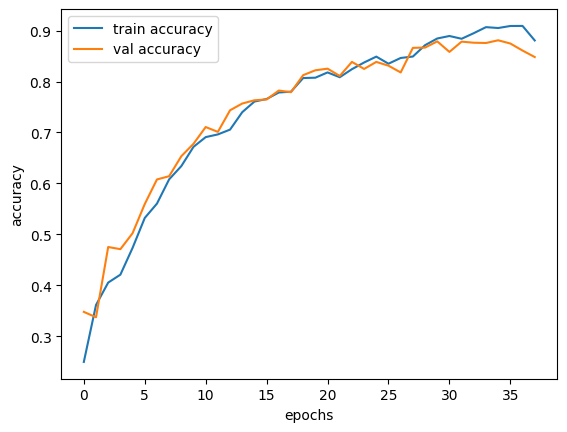

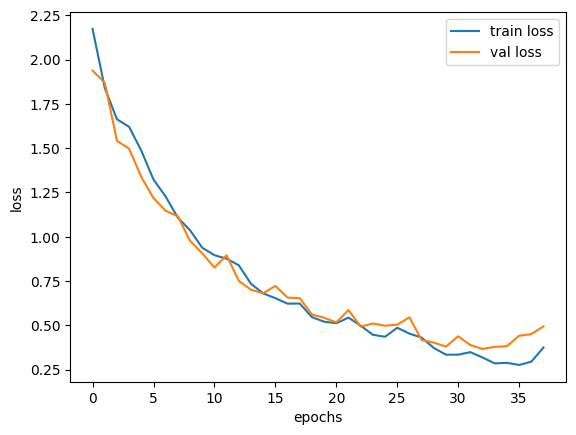

In [ ]:
plot_metrics(historys[0])

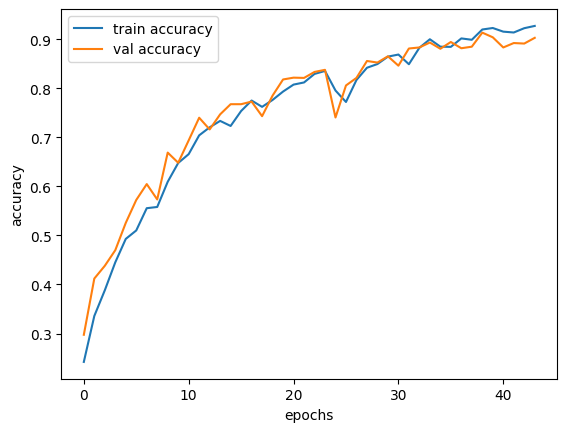

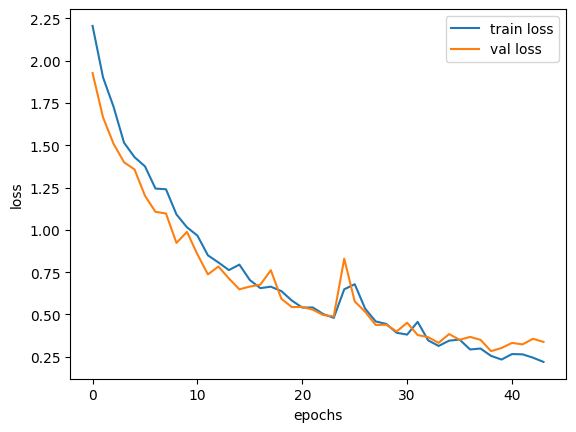

In [ ]:
plot_metrics(historys[1])

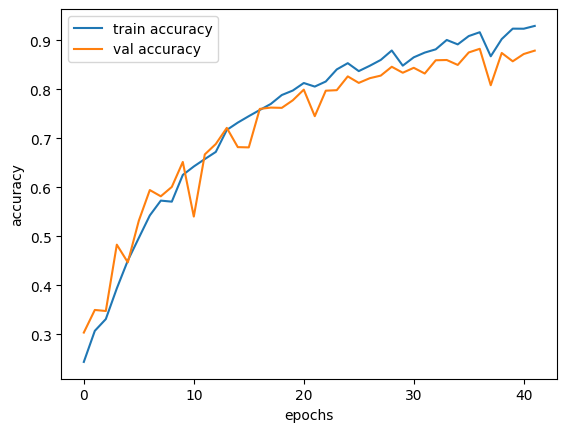

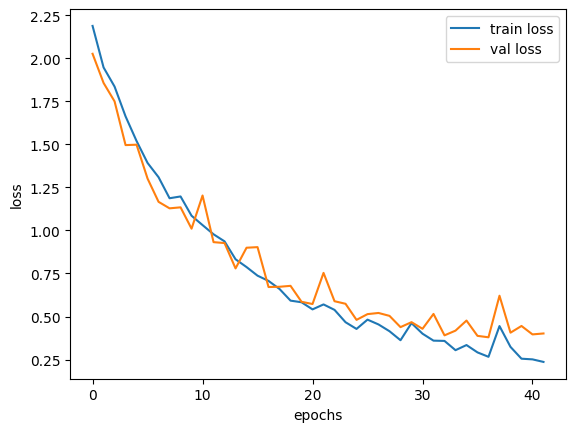

In [ ]:
plot_metrics(historys[2])

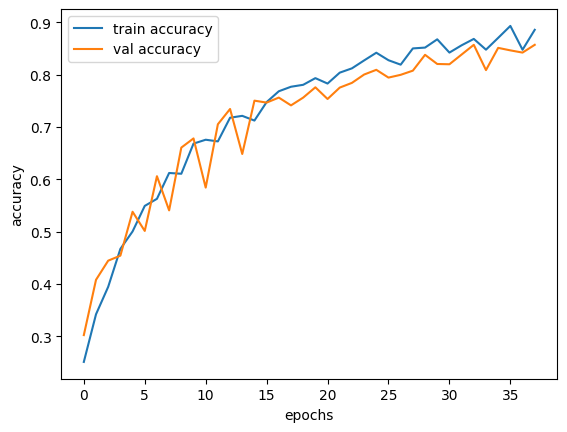

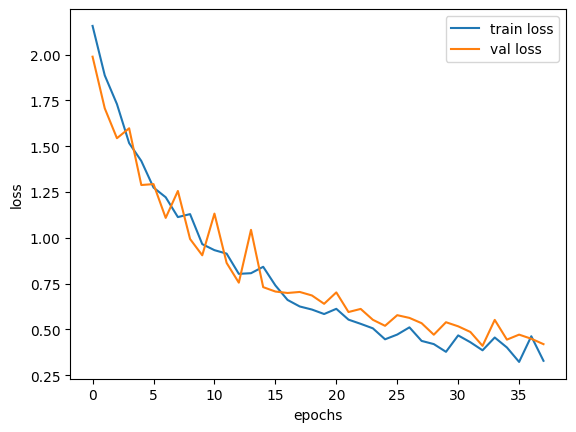

In [ ]:
plot_metrics(historys[3])

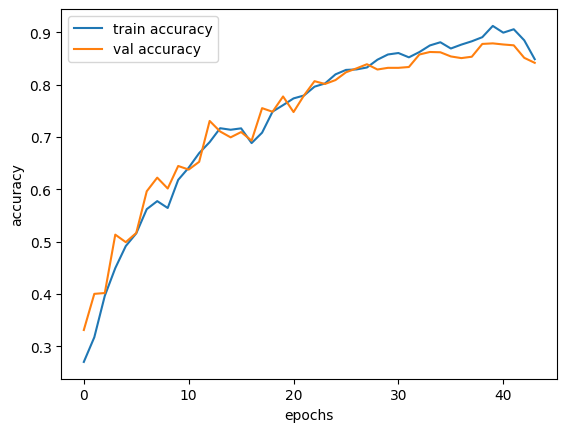

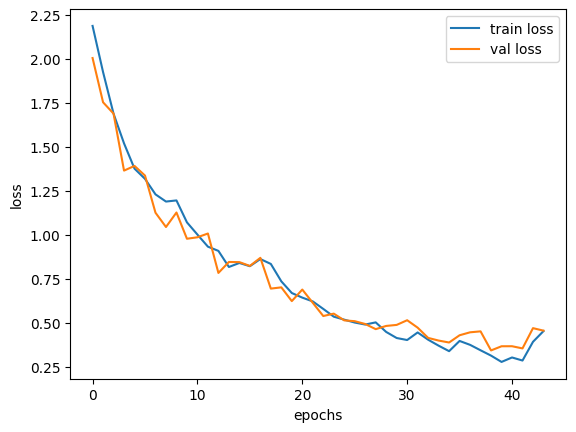

In [ ]:
plot_metrics(historys[4])

In [ ]:
predict = model.predict(x_test)
predict = np.argmax(predict, axis=1)

74/74 [==============================] - 2s 9ms/step


In [ ]:
accuracy_score(predict, y_test)

0.8904458598726115

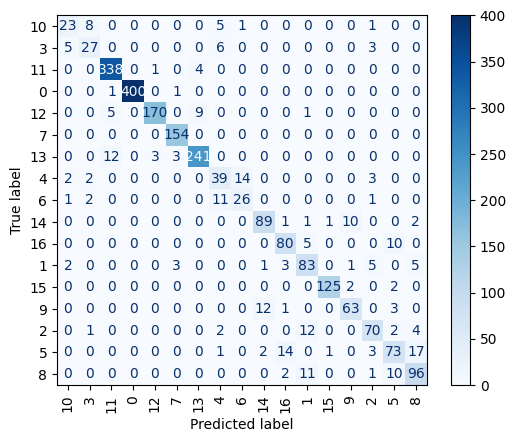

In [ ]:
classes_names = {'0','1', '2','3','4','5','6', '7', '8', '9', '10','11','12', '13','14','15','16'}
cm = confusion_matrix(y_test, predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= classes_names)

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.show()

In [ ]:
print(classification_report(y_test, predict, target_names=classes_names))

              precision    recall  f1-score   support

          10       0.70      0.61      0.65        38
           3       0.68      0.66      0.67        41
          11       0.95      0.99      0.97       343
           0       1.00      1.00      1.00       402
          12       0.98      0.92      0.95       185
           7       0.96      1.00      0.98       154
          13       0.95      0.93      0.94       259
           4       0.61      0.65      0.63        60
           6       0.63      0.63      0.63        41
          14       0.86      0.86      0.86       104
          16       0.79      0.84      0.82        95
           1       0.73      0.81      0.77       103
          15       0.98      0.97      0.98       129
           9       0.83      0.80      0.81        79
           2       0.80      0.77      0.79        91
           5       0.73      0.66      0.69       111
           8       0.77      0.80      0.79       120

    accuracy              